In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from wordcloud import WordCloud, STOPWORDS

#visualization:
from Vis_func import bar_plot, count_plot, reformat_large_tick_values

# Exploratory data analysis

In [182]:
#Data
df = pd.read_csv('KinoPoisk_processed')


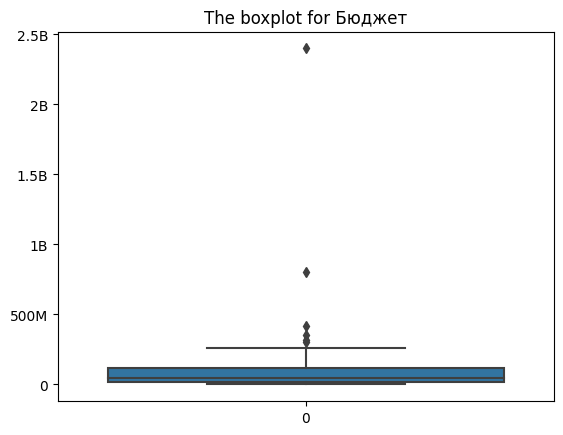

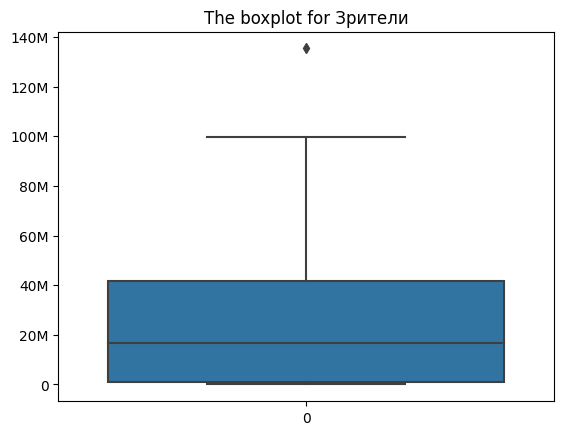

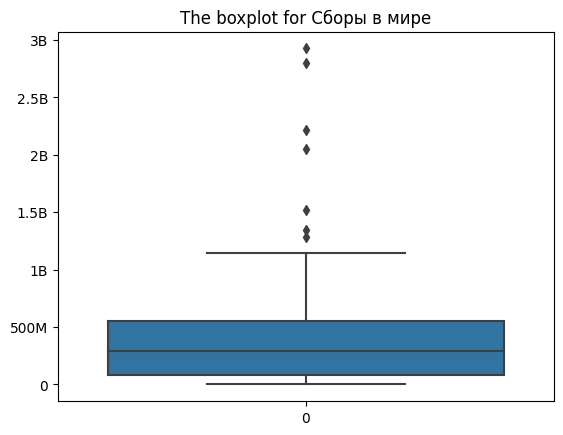

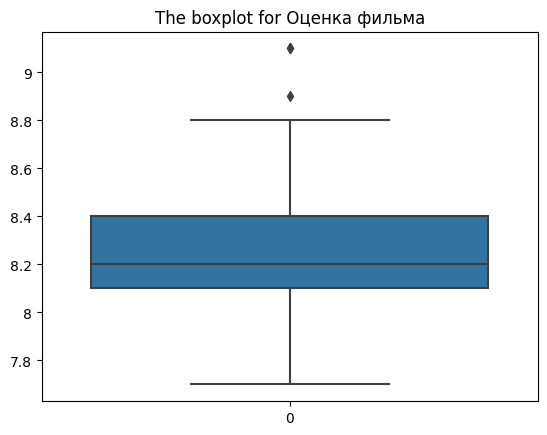

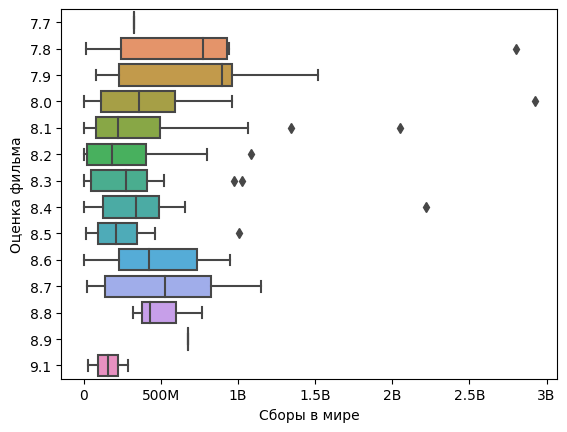

In [183]:
numeric_cols = ['Бюджет', 'Зрители', 'Сборы в мире', 'Оценка фильма']
for col in numeric_cols:
    sns.boxplot(df[col])
    ax = plt.gca()
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    plt.title(f'The boxplot for {col}')
    plt.show()

sns.boxplot(x=df['Сборы в мире'], y=df['Оценка фильма'], orient='h')
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.show()

## Part 2: Visualization

#### Histograms

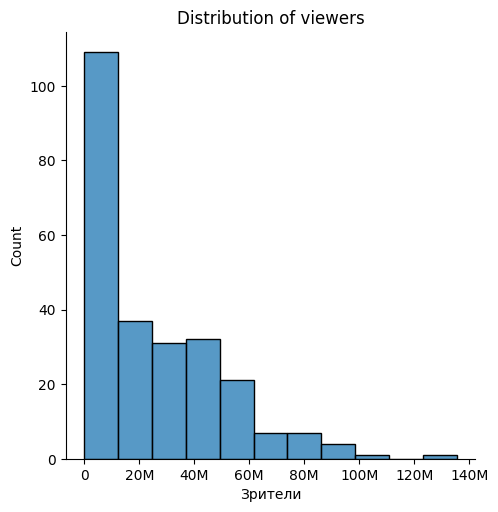

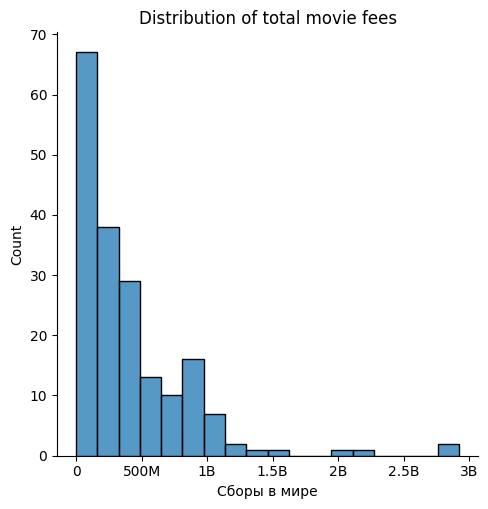

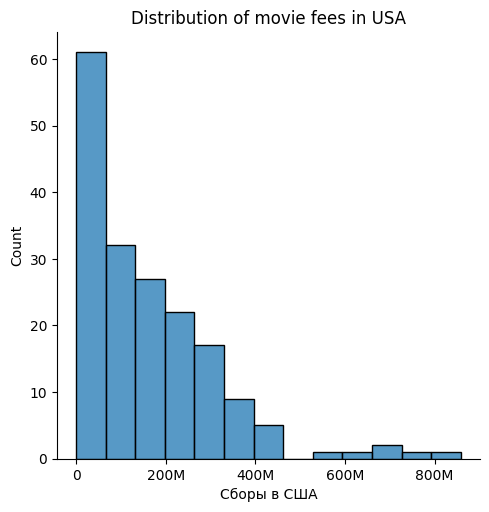

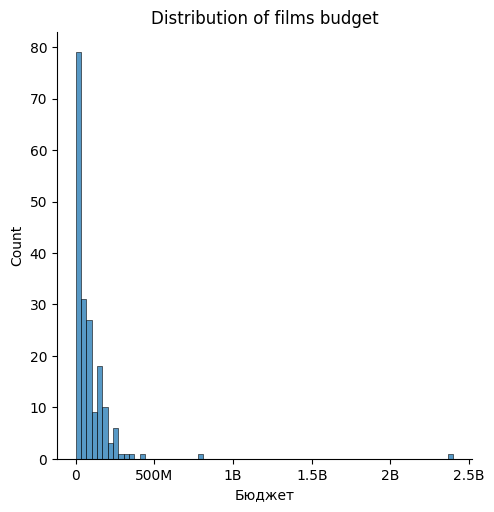

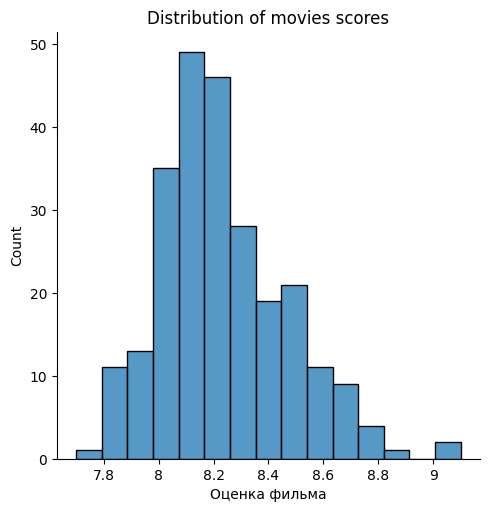

In [184]:
cols = ['Зрители', 'Сборы в мире', 'Сборы в США', 'Бюджет', 'Оценка фильма']
titles = ['Distribution of viewers', 'Distribution of total movie fees', 'Distribution of movie fees in USA', 'Distribution of films budget', 'Distribution of movies scores']
for col in cols:
    sns.displot(df[col])
    plt.title(titles[cols.index(col)])
    ax = plt.gca()
    ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    plt.show()

### Word cloud

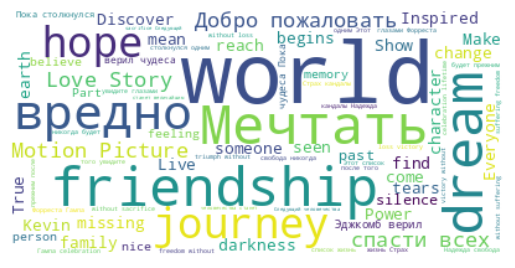

In [185]:
text = " ".join(review for review in df['Слоган'])

stopwords = set(STOPWORDS)
stopwords.update(["Beyond", "will", 'может'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white", min_word_length=4, collocation_threshold=10).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## The below graphs should be created in dashboard

#### Time-series plots

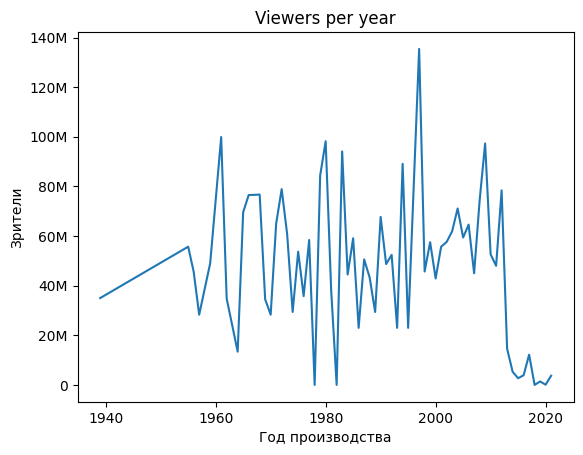

In [186]:
viewers_per_year = df.groupby('Год производства')['Зрители'].max()
sns.lineplot(viewers_per_year)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.title('Viewers per year')
plt.show()

### Categorical analysis

#### Genre

In [188]:
count_plot(df=df, name_of_category_column='Жанр', title_name='Количество фильмов каждого жанра').show()
bar_plot(df=df, name_of_category_column='Жанр', name_of_measerment_column='Сборы в мире',title_name='Средние сборы фильма по жанрам в долларах').show()
bar_plot(df=df, name_of_category_column='Жанр', name_of_measerment_column='Сборы в США', title_name='Средние сборы фильма в США по жанрам в долларах').show()
bar_plot(df=df, name_of_category_column='Жанр', name_of_measerment_column='Зрители', title_name='Среднее кол-во зрителей фильма по жанрам').show()
bar_plot(df=df, name_of_category_column='Жанр', name_of_measerment_column='Оценка фильма', title_name='Средняя оценка фильма по жанрам', scale_of_axis=[8,8.5]).show()

ValueError: Cannot accept list of column references or list of columns for both `x` and `y`.

#### Country

In [ ]:
count_plot(df=df, name_of_category_column='Страна', title_name='Кол-во фильмов по странам производства').show()
bar_plot(df=df, name_of_category_column='Страна', name_of_measerment_column='Сборы в мире', title_name='Средние сборы фильма в мире по странам производства').show()
bar_plot(df=df, name_of_category_column='Страна', name_of_measerment_column='Сборы в США', title_name='Средние сборы фильма в США по странам производства').show()
bar_plot(df=df, name_of_category_column='Страна', name_of_measerment_column='Зрители', title_name='Среднее кол-во зрителей по странам производства').show()
bar_plot(df=df, name_of_category_column='Страна', name_of_measerment_column='Оценка фильма', title_name='Средняя оценка фильмов по странам производства', scale_of_axis=[7.8,8.7]).show()

ValueError: Cannot accept list of column references or list of columns for both `x` and `y`.

#### Producer

#### Screenwriter

#### Actors